In [49]:
%reset -f
import time
import numpy as np
import sympy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
from scipy.integrate import solve_bvp

# from tueplots.bundles import probnum2025
# plt.rcParams.update(probnum2025())


## 0. Solutions to the TOV-Equations and Source/Matter Terms

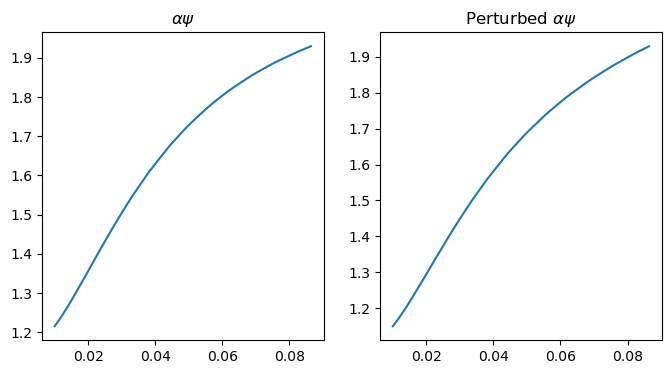

In [101]:
# Load the variables from tov-final
r_o   = 1.0e+3          # outer radius (maximum radius)
r_c   = 1.0e-1          # central radius (minimum radius)
P_c   = 1.0e-1          # central pressure (maximal pressure)

# Specify and load the file
filename    = f'../../data/tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}.npy'
filename    = f'../../data/tov_112.npy'
loaded_data = np.load(filename)

# Unpack the values
r, m, P, rho, R, alpha, psi = loaded_data

# Interpolate all the data (in oversampled form) to allow for a linear grid
m_intp     = interpolate.interp1d(R, m,     kind='linear', bounds_error=False)
P_intp     = interpolate.interp1d(R, P,     kind='linear', bounds_error=False)
rho_intp   = interpolate.interp1d(R, rho,   kind='linear', bounds_error=False)
alpha_intp = interpolate.interp1d(R, alpha, kind='linear', bounds_error=False)
psi_intp   = interpolate.interp1d(R, psi,   kind='linear', bounds_error=False)

# Convert to linear grid
nb_points = 50
R = np.linspace(np.min(R)+1e-2, np.max(R), nb_points)

m      = m_intp(R)
P      = P_intp(R)
rho    = rho_intp(R)
alpha  = alpha_intp(R)
psi    = psi_intp(R)

# A large perturbation can be used as an initialization of psi
# Perturbation parameters
center_value  = 0.3        # Center value
sigma         = 1.0e-1     # Width of the full Gaussian
amplitude     = 1.0e-1      # Scale factor

# Construction of the perturbation
center_index  = np.argmin(np.abs(R - center_value))
R_centered    = (R - R[center_index])/R[center_index]
gaussian      = amplitude * np.exp(-((R - R[center_index]) ** 2) / (2 * sigma**2))
alpha_psi_perturbation = gaussian * R_centered

# Define the perturbed density
perturbed_alpha_psi = alpha*psi + alpha_psi_perturbation

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(R, alpha*psi)
ax[0].set_title(r"$\alpha \psi$")
ax[1].plot(R, perturbed_alpha_psi)
ax[1].set_title(r"Perturbed $\alpha \psi$");


## 1. Problem Definition

Given the perturbation on the density, the vector equations are trivially zero.

The second scalar equation to solve is:
\begin{equation}
    \nabla^{2}  \left( (\alpha \psi)_{(n+1)} + C \right) = \left( (\alpha \psi)_{(n)} + C \right) S_{\alpha\psi}
\end{equation}
in which $S_{\alpha \psi} = 2 \pi (E + 2S) / (\psi^2) \cdot \psi^6 = 2 \pi (\rho + 6p) \cdot \psi^4$

## 2. Solver

In [102]:
# Definition of the source term S1
S_alpha_psi = 2*np.pi*(rho + 6*P)*psi**4

# Symbol nomenclature
r     = sp.symbols('r')
n     = sp.symbols('n')
R_max = sp.symbols('R_max')

# Definition of the basis functions
basis_func = sp.sqrt(2) * sp.sin(n * sp.pi * r / R_max) / (r * n**2)

# Definition of the laplacian operator
laplacian = lambda r, func: sp.diff(func, r, 2) + 2 / r * sp.diff(func, r)


In [103]:
# Function definitions
# 1a. Construction of the source term
def construct_source_term(alpha_psi):
    return alpha_psi * S_alpha_psi

# 1b. Construction of the design matrix
def construct_design_matrix(R, N, basis_func, laplacian):
    
    # Lambdify the functions
    basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)
    laplacian_lambd = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))

    # Matrix initialization
    basis_func_matrix = np.zeros((len(R), N))
    design_matrix = np.zeros((len(R), N))

    # Construction of the basis function and design matrix
    # Avoid i equal to one as that introduces problems with the sinc function
    for i in range(1, N+1):
        # Regular ODE solution
        basis_func_matrix[:, i-1] = basis_func_lambd(R, i, max(R))
        design_matrix[:,  i-1] = laplacian_lambd(R, i, max(R))

    return basis_func_matrix, design_matrix

# 2. ODE solver
def solve_ode(basis_func_matrix, design_matrix, observations, likelihood_precision, prior_precision, prior_mean):
    
    # Reformulate the problem into an A @ w = b problem, and solve the least-squares (in the "classical perspective")
    w_precision_matrix = design_matrix.T @ likelihood_precision @ design_matrix + prior_precision
    b = np.expand_dims(design_matrix.T @ likelihood_precision @ observations, axis=1)

    # Solve the system
    w_mu = np.linalg.solve(w_precision_matrix, b)

    # Computation of the source function mean
    source_func_mean_primal = design_matrix @ w_mu
    source_func_mean_primal = np.squeeze(source_func_mean_primal)
    
    # Computation of the source function variance
    v = np.linalg.solve(w_precision_matrix, design_matrix.T)
    source_func_variance_primal = design_matrix @ v
    
    # Computation of the solution mean
    solution_mean_primal = basis_func_matrix @ w_mu
    solution_mean_primal = np.squeeze(solution_mean_primal)
    
    # Computation of the solution variance
    v = np.linalg.solve(w_precision_matrix, basis_func_matrix.T)
    solution_variance_primal = basis_func_matrix @ v

    return solution_mean_primal, solution_variance_primal, source_func_mean_primal, source_func_variance_primal, w_mu, w_precision_matrix
    

### 2.1 Initialization: Correct Solution
The estimation is correct, however, more numerical steps increases the deviation from the correct solution


00%|███████████████████████████████████████████| 5/5 [00:00<00:00, 1623.18it/s]

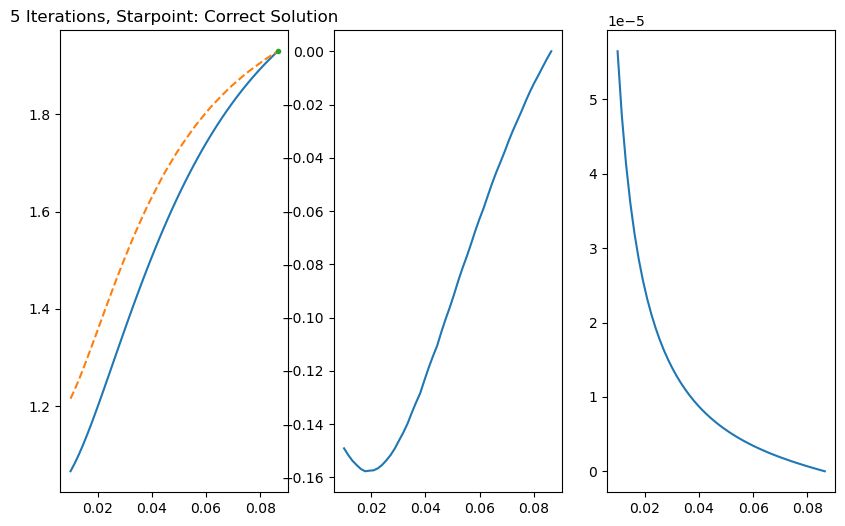

In [107]:
alpha_psi_init = alpha*psi
N = 25                               # Number of basis functions
S = 1.0e-4*np.identity(len(R))     # Sigma matrix
L = 1.0e4*np.identity(N)             # 

# Define the arrays which store the variables
iteration_steps              = 5
alpha_psi_mean_storage       = np.zeros((len(psi), iteration_steps+1))
alpha_psi_var_storage        = np.zeros((len(psi), len(psi), iteration_steps+1))

# Initialization
alpha_psi_mean_storage[:, 0] = alpha_psi_init

# Boundary condition value
y_BC2 = alpha[-1]*psi[-1] 

basis_func_matrix, design_matrix = construct_design_matrix(R, N, basis_func, laplacian)
source_term = construct_source_term(alpha_psi_init)

for i in tqdm(range(1, iteration_steps + 1)):
    
    # Solve the ODE
    solution_mean_primal, solution_variance_primal, _, _, A, w = solve_ode(basis_func_matrix, design_matrix, source_term, np.linalg.inv(S), np.linalg.inv(L), np.squeeze(np.zeros((N,1))))
    
    # Storage
    alpha_psi_mean_storage[:, i] = solution_mean_primal
    alpha_psi_var_storage[:,:,i] = solution_variance_primal

    # Construct the new source term
    source_term = construct_source_term(solution_mean_primal + y_BC2)

fig, ax = plt.subplots(1,3, figsize=(10,6))

ax[0].plot(R, solution_mean_primal + y_BC2, label="Solution from Nonlinear Problem")
solution_std = np.sqrt(np.diag(solution_variance_primal))
ax[0].fill_between(R, solution_mean_primal + y_BC2 - solution_std, solution_mean_primal + y_BC2 + solution_std, alpha=0.15)
ax[0].plot(R, alpha*psi, ls='--', label="Ground Truth")
ax[0].plot(np.max(R), y_BC2, marker='.', ls='none', label="Initial Condition")
ax[0].set_title("5 Iterations, Starpoint: Correct Solution")


ax[1].plot(R, solution_mean_primal + y_BC2 - alpha*psi)

ax[2].plot(R, solution_std);

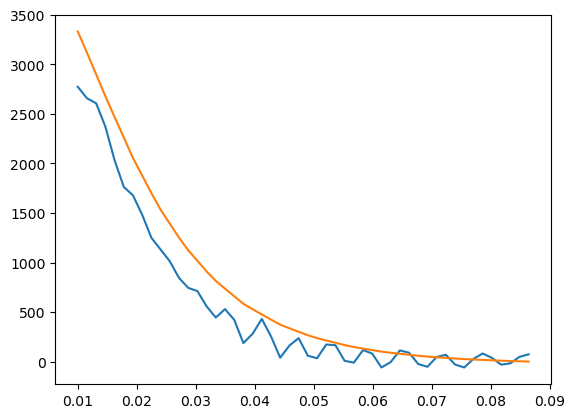

In [111]:
lhs = np.gradient(np.gradient(alpha_psi_init, R), R) + 2/R*np.gradient(alpha_psi_init, R)
rhs = alpha_psi_init*S_alpha_psi
plt.plot(R, lhs)
plt.plot(R, rhs)

## Implementation does not yet work

In [14]:
# Function definitions
# 1a. Construction of the source term
def construct_source_term(psi):
    return S1 / psi

# 1b. Construction of the design matrix
def construct_design_matrix(R, N, basis_func, laplacian):
    
    # Lambdify the functions
    basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)
    laplacian_lambd = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))

    # Matrix initialization
    basis_func_matrix = np.zeros((len(R), N))
    design_matrix = np.zeros((len(R), N))

    # Construction of the basis function and design matrix
    # Avoid i equal to one as that introduces problems with the sinc function
    for i in range(1, N+1):
        # Regular ODE solution
        basis_func_matrix[:, i-1] = basis_func_lambd(R, i, max(R))
        design_matrix[:,  i-1] = laplacian_lambd(R, i, max(R))

    return basis_func_matrix, design_matrix

# 2. ODE solver
def solve_ode(basis_func_matrix, design_matrix, observations, likelihood_precision, prior_precision, prior_mean):
    
    # Reformulate the problem into an A @ w = b problem, and solve the least-squares (in the "classical perspective")
    w_precision_matrix = design_matrix.T @ likelihood_precision @ design_matrix + prior_precision
    b = design_matrix.T @ likelihood_precision @ observations + np.squeeze(prior_precision @ prior_mean)

    # Solve the system
    w_mu = np.linalg.solve(w_precision_matrix, b)

    # Computation of the source function mean
    source_func_mean_primal = design_matrix @ w_mu
    source_func_mean_primal = np.squeeze(source_func_mean_primal)
    
    # Computation of the source function variance
    v = np.linalg.solve(w_precision_matrix, design_matrix[:-1,:].T)
    source_func_variance_primal = design_matrix @ v
    
    # Computation of the solution mean
    solution_mean_primal = basis_func_matrix @ w_mu
    solution_mean_primal = np.squeeze(solution_mean_primal)
    
    # Computation of the solution variance
    v = np.linalg.solve(w_precision_matrix, basis_func_matrix.T)
    solution_variance_primal = basis_func_matrix @ v

    return solution_mean_primal, solution_variance_primal, source_func_mean_primal, source_func_variance_primal, w_mu, w_precision_matrix


# ==================================================================
# Actual solving
# ================================================================== 

psi_init = perturbed_psi 
N = 10                               # Number of basis functions

s = 10**(0) 
l = 10**(12)

S = s*np.identity(len(R))     # Sigma matrix
L = l*np.identity(N)             # 

# Define the arrays which store the variables
iteration_steps        = 100
psi_mean_storage       = np.zeros((len(psi), iteration_steps+1))
psi_var_storage        = np.zeros((len(psi), len(psi), iteration_steps+1))

# Initialization
psi_mean_storage[:, 0] = psi_init

# Boundary condition value
y_BC2 = psi[-1] 

basis_func_matrix, design_matrix = construct_design_matrix(R, N, basis_func, laplacian)
source_term = construct_source_term(psi_init)

# initialize
w_prev = np.squeeze(np.zeros((N,1)))
w_precision_prev = np.linalg.inv(L)
likelihood_precision_prev = np.linalg.inv(S)

for i in tqdm(range(1, iteration_steps + 1)):
    
    # Solve the ODE
    solution_mean_primal, solution_variance_primal, _, _, w_mu, w_precision_matrix = solve_ode(basis_func_matrix, design_matrix, source_term, likelihood_precision_prev, w_precision_prev, w_prev)
    
    # Storage
    psi_mean_storage[:, i] = solution_mean_primal
    psi_var_storage[:,:,i] = solution_variance_primal

    # Construct the new source term

    # ===> I am still very doubtful about this part of the code; i.e. how do we encode the uncertainty exactly?
    source_term = construct_source_term(solution_mean_primal + y_BC2)
    Jf = np.diag(-S1/(solution_mean_primal + y_BC2)**2)
    # Jf[-1,:] = np.zeros_like(Jf[-1,:])
    # Jf[:,-1] = np.zeros_like(Jf[:,-1])
    
    # I assume this remains the original one as the solver is not able to update this
    Jf[-1, -1] = s**(-1)
    # Numerical stabilizer added to this
    # ===> This expression works but seems incorrect
    #likelihood_precision_prev = 1.0e-12*np.identity(len(R)) + np.linalg.inv(Jf @ (likelihood_precision_prev) @ Jf.T)

    # 2. Another approach (works if S < 1)
    likelihood_precision_prev = np.linalg.inv(S) + np.linalg.inv(Jf @ np.linalg.inv(likelihood_precision_prev) @ Jf.T)
    
    # 3. ===> This expression does not converge to the correct solution, but should be correct.
    # likelihood_precision_prev = 1.0e-12*np.identity(len(R)) + np.linalg.inv(Jf @ np.linalg.inv(likelihood_precision_prev) @ Jf.T)
    
    # Update the covariance matrices
    w_prev = w_mu
    w_precision_prev = w_precision_matrix
    

fig, ax = plt.subplots(1,3, figsize=(10,6))

ax[0].plot(R, (solution_mean_primal + y_BC2), label="Solution from Nonlinear Problem")
solution_std = np.sqrt(np.diag(solution_variance_primal))
ax[0].fill_between(R, solution_mean_primal + y_BC2 - solution_std, solution_mean_primal + y_BC2 + solution_std, alpha=0.15)
ax[0].plot(R, psi, ls='--', label="Ground Truth")
ax[0].set_title("5 Iterations, Starpoint: Correct Solution")


ax[1].plot(R, solution_mean_primal + y_BC2 - psi)

ax[2].plot(R, solution_std);

NameError: name 'perturbed_psi' is not defined